In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras import layers, models, optimizers, utils, regularizers
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
assert(tf.test.gpu_device_name())

2022-03-29 17:26:36.418418: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-29 17:26:36.447207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 17:26:36.484542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 17:26:36.484858: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
'''
    Cria uma função (int_func) que transforma cada string num inteiro. numpy.vectorize aplica essa função elemento por elemento
'''

int_func=lambda x: int(x)
vint_func=np.vectorize(int_func)

In [4]:
'''
    Cria uma função (ord_func) que transforma cada string num inteiro. numpy.vectorize aplica essa função elemento por elemento
'''

ord_func=lambda x: ord(x)
vord_func=np.vectorize(ord_func)

In [5]:
'''
    Lê os arquivos com os arrays das imagens. Divide por 255 para normalizar, pois as imagens eram grayscale. Expande o shape do array, 
    pois o keras precisa ler as entradas com 4 dimensões (batch_shape, rows, cols, channels). 
'''

training_img_char=np.expand_dims(np.load('training_img_char.npy').astype('float32')/255,axis=-1)
training_img_digit=np.expand_dims(np.load('training_img_digit.npy').astype('float32')/255,axis=-1)
testing_img_char=np.expand_dims(np.load('testing_img_char.npy').astype('float32')/255,axis=1)
testing_img_digit=np.expand_dims(np.load('testing_img_digit.npy').astype('float32')/255,axis=-1)
validation_img_char=np.expand_dims(np.load('validation_img_char.npy').astype('float32')/255,axis=-1)
validation_img_digit=np.expand_dims(np.load('validation_img_digit.npy').astype('float32')/255,axis=-1)

In [6]:
'''
    Lê os arquivos com os arrays dos labels. Notar que tais arrays contêm strings. Será necessário convertê-los para int usando
    a função ord(), quando o label for caractere, e int(), quando for inteiro. Cria o one-hot encode 
'''

training_label_char=utils.to_categorical(vord_func(np.load('training_label_char.npy')))
training_label_digit=utils.to_categorical(vint_func(np.load('training_label_digit.npy')))
testing_label_char=utils.to_categorical(vord_func(np.load('testing_label_char.npy')))
testing_label_digit=utils.to_categorical(vint_func(np.load('testing_label_digit.npy')))
validation_label_char=utils.to_categorical(vord_func(np.load('validation_label_char.npy')))
validation_label_digit=utils.to_categorical(vint_func(np.load('validation_label_digit.npy')))

##### Primeiro modelo para os dígitos

In [9]:
modelo1 = models.Sequential([
    layers.Conv2D(64,
                  (3,3),
                  activation='relu',
                  input_shape=(17,11,1),
                  padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Conv2D(64,
                 (3,3),
                 activation='relu',
                 padding='same'),
    layers.MaxPooling2D(pool_size=(2,2),
                       strides=2),
    layers.Flatten(),
    layers.Dense(256,
                activation='relu'),
    layers.Dense(10,
                activation='softmax')
])

2022-03-29 17:26:56.166210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 17:26:56.166535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 17:26:56.166735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 17:26:56.167157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 17:26:56.167367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
modelo1.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
hist_modelo1=modelo1.fit(training_img_digit, training_label_digit, 
                 epochs=30,
                 batch_size=512,
                 validation_data=(validation_img_digit, validation_label_digit))

Epoch 1/30


2022-03-29 17:27:01.314638: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-03-29 17:27:01.668902: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


15/15 [==============================] - 2s 25ms/step - loss: 2.2365 - accuracy: 0.1690 - val_loss: 2.1952 - val_accuracy: 0.1211
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 1.9113 - accuracy: 0.4108 - val_loss: 1.7865 - val_accuracy: 0.5322
Epoch 3/30
15/15 [==============================] - 0s 11ms/step - loss: 1.4894 - accuracy: 0.6115 - val_loss: 1.3784 - val_accuracy: 0.6950
Epoch 4/30
15/15 [==============================] - 0s 11ms/step - loss: 1.1272 - accuracy: 0.7439 - val_loss: 1.1226 - val_accuracy: 0.7536
Epoch 5/30
15/15 [==============================] - 0s 11ms/step - loss: 0.8092 - accuracy: 0.8174 - val_loss: 0.9283 - val_accuracy: 0.8017
Epoch 6/30
15/15 [==============================] - 0s 11ms/step - loss: 0.5554 - accuracy: 0.8889 - val_loss: 0.7672 - val_accuracy: 0.8256
Epoch 7/30
15/15 [==============================] - 0s 11ms/step - loss: 0.3806 - accuracy: 0.9285 - val_loss: 0.6607 - val_accuracy: 0.8300
Epoch 8/30
15/15 [======

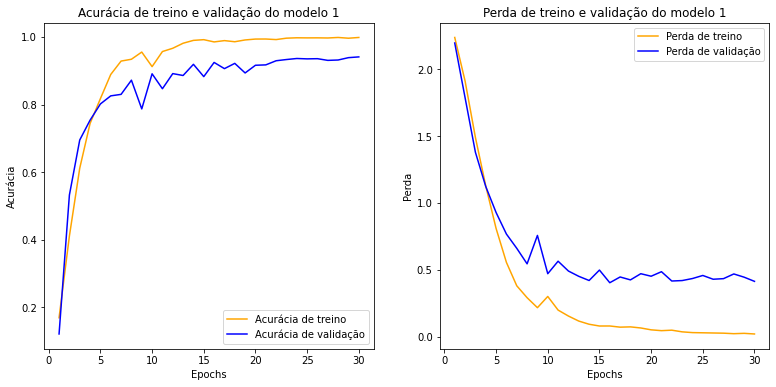

In [12]:
epochs=range(1,len(hist_modelo1.history['accuracy'])+1)

plt.rcParams["figure.figsize"] = (13,6)

plt.subplot(1, 2, 1)

plt.plot(epochs, hist_modelo1.history['accuracy'], color='orange', label='Acurácia de treino')
plt.plot(epochs,hist_modelo1.history['val_accuracy'], 'b', label ='Acurácia de validação')
plt.title('Acurácia de treino e validação do modelo 1')
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(epochs, hist_modelo1.history['loss'], color='orange', label='Perda de treino')
plt.plot(epochs,hist_modelo1.history['val_loss'], 'b', label ='Perda de validação')
plt.title('Perda de treino e validação do modelo 1')
plt.xlabel('Epochs')
plt.ylabel('Perda')
plt.legend()

plt.show()